In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [3]:
df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature engineering

In [4]:
# Feature engineering (unchanged)
df_date_only = df_main['createdAt']
df_date_only = pd.to_datetime(df_date_only)
df_date_only = df_date_only.dt.date
df_main['only_date'] = df_date_only

df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days

df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

### Data prepare

In [5]:
num_cols = ['subtotal', 'travelingExpense', 'discountNum', 'orders_last_365d']
cat_cols = ['defaultPaymentMethod', 'mode', 'serviceClassificationName', 'state',
            'address_county', 'address_district', 'discount_type', 'isServicePackageBooking']
X = df_main[num_cols + cat_cols].copy()

In [6]:
# Ensure data types
for col in num_cols:
    X[col] = X[col].astype(float)
for col in cat_cols:
    X[col] = X[col].astype(str)

### Analysis

#### Numerical vs. Numerical

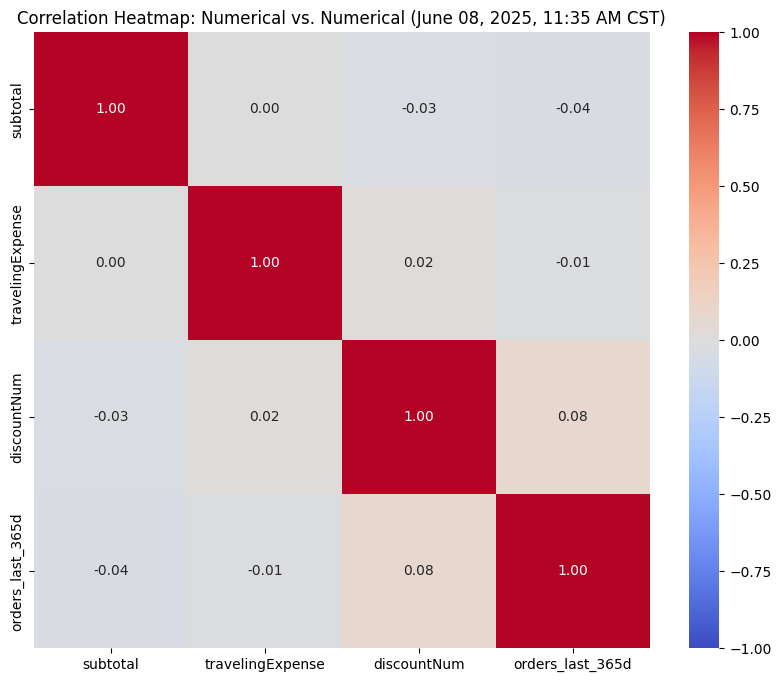

In [7]:
# Load and prepare data (assuming df_main is already loaded)
num_cols = ['subtotal', 'travelingExpense', 'discountNum','orders_last_365d']
X = df_main[num_cols].copy()
for col in num_cols:
    X[col] = X[col].astype(float)

# Compute Pearson correlation matrix
num_corr = X.corr(method='pearson')

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(num_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, fmt='.2f')
plt.title('Correlation Heatmap: Numerical vs. Numerical (June 08, 2025, 11:35 AM CST)')
plt.show()

#### Categorical vs. Categorical Correlation Chart

<Figure size 1200x600 with 0 Axes>

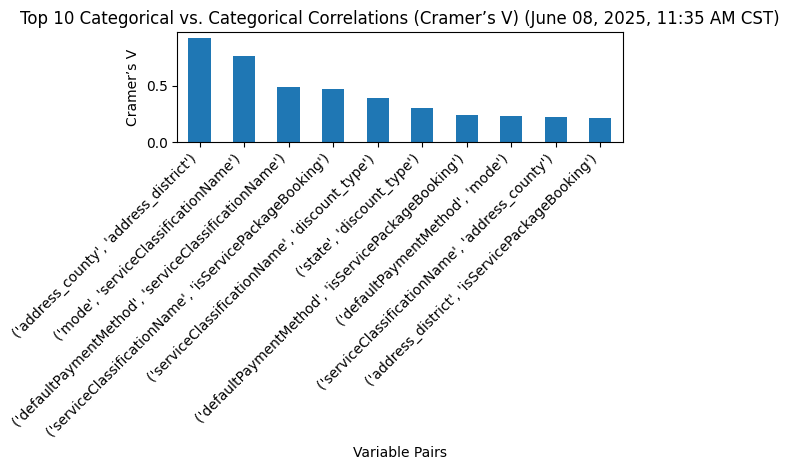

In [8]:
# Prepare data
cat_cols = ['defaultPaymentMethod', 'mode', 'serviceClassificationName', 'state',
            'address_county', 'address_district', 'discount_type','isServicePackageBooking']
X = df_main[cat_cols].copy()
for col in cat_cols:
    X[col] = X[col].astype(str)

# Compute Cramer’s V for all pairs
cat_corrs = {}
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        contingency_table = pd.crosstab(X[col1], X[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
        cat_corrs[(col1, col2)] = cramers_v

# Convert to DataFrame and sort by correlation
cat_corr_df = pd.DataFrame.from_dict(cat_corrs, orient='index', columns=['Cramer’s V'])
cat_corr_df = cat_corr_df.sort_values(by='Cramer’s V', ascending=False).head(10)  # Top 10 pairs

# Create bar chart
plt.figure(figsize=(12, 6))
cat_corr_df.plot(kind='bar', legend=False)
plt.title('Top 10 Categorical vs. Categorical Correlations (Cramer’s V) (June 08, 2025, 11:35 AM CST)')
plt.xlabel('Variable Pairs')
plt.ylabel('Cramer’s V')
plt.xticks(ticks=range(len(cat_corr_df.index)), labels=cat_corr_df.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()